In [24]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install h2o

In [25]:

from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [15]:
df_main_1 = pd.read_csv('/content/train _house.csv')


In [16]:
df_main_1

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [17]:
df_main_copy = df_main_1.copy()

In [18]:

for col in df_main_1.columns:
    if df_main_1[col].dtype == object:
        try:
            df_main_1[col] = pd.to_numeric(df_main_1[col])
        except ValueError:
            try:
                df_main_1[col] = pd.to_datetime(df_main_1[col])
            except ValueError:
                pass
def null_handling(df_main, null_method = None, columns_name = None,):
  if null_method == 'Deletion':
    df_main = df_main.drop(columns = columns_name)

  elif null_method == 'Mean Imputing':
    imputer = SimpleImputer(strategy='mean')
    df_main = imputer.fit_transform(df_main[columns_name])

  elif null_method == 'Mode Imputing':
    imputer = SimpleImputer(strategy='most_frequent')
    df_main = imputer.fit_transform(df_main[columns_name])

  elif null_method == 'Median Imputing' :
    imputer = SimpleImputer(strategy='median')
    df_main = imputer.fit_transform(df_main[columns_name])

  else:
    df_main = df_main.copy()

  return df_main

def encoding(df_main, encoding_method = None, categorical_columns = None):
  #categorical_columns = df_main.select_dtypes(include=['object']).columns.tolist()
  if encoding_method == 'Delete':
    df = df_main.drop(columns = categorical_columns)

  elif encoding_method == 'Label Encoding':
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    label_encoder = LabelEncoder()
    for column in categorical_columns:
      df_main_copy[column] = label_encoder.fit_transform(df_main_copy[column])
    #df = df_main_copy.drop(columns=categorical_columns)
    df = df_main_copy

  elif encoding_method == 'Create Dummies':
    print('#################')
    dummy_df = pd.get_dummies(df_main[categorical_columns], drop_first=True)
    # Concatenate the dummy variables with the original DataFrame
    df = pd.concat([df_main.drop(columns=categorical_columns), dummy_df], axis=1)

  else:
    df = df_main.copy()

  return df

numerical_columns = df_main_1.select_dtypes(include = ['int64','float64']).columns.tolist()
df_main_num = null_handling(df_main_1,'Mean Imputing', numerical_columns)
df_main_num = pd.DataFrame(df_main_num, columns=numerical_columns)  # Convert to DataFrame


categorical_columns_null = df_main_1.select_dtypes(include = ['object']).columns.tolist()
df_main_cat = null_handling(df_main_1,'Mode Imputing', categorical_columns_null)
df_main_cat = pd.DataFrame(df_main_cat, columns=categorical_columns_null)  # Convert to DataFrame


df_main = pd.concat([df_main_num, df_main_cat], axis=1)

categorical_columns = df_main.select_dtypes(include=['object']).columns.tolist()
df = encoding(df_main,'Create Dummies',categorical_columns )


#################


In [19]:
y = df['SalePrice']
X = df.drop(['SalePrice'], axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Prepares a default instance of the random forest regressor
model = RandomForestRegressor()
# Fits the model on the data
model.fit(X_train, y_train)

RandomForestRegressor()

In [26]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 293it [01:24,  3.36it/s]


The shap_values variable will have three attributes: .values, .base_values and .data.

The .dataattribute is simply a copy of the input data, .base_values is the expected value of the target, or the average target value of all the train data, and .values are the SHAP values for each example.

If we are only interested in the SHAP values, we can use the explainer.shap_values() method:

In [28]:
explainer.shap_values(X)

Permutation explainer:  25%|██▍       | 360/1460 [06:00<18:51,  1.03s/it]


KeyboardInterrupt: ignored

In [41]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


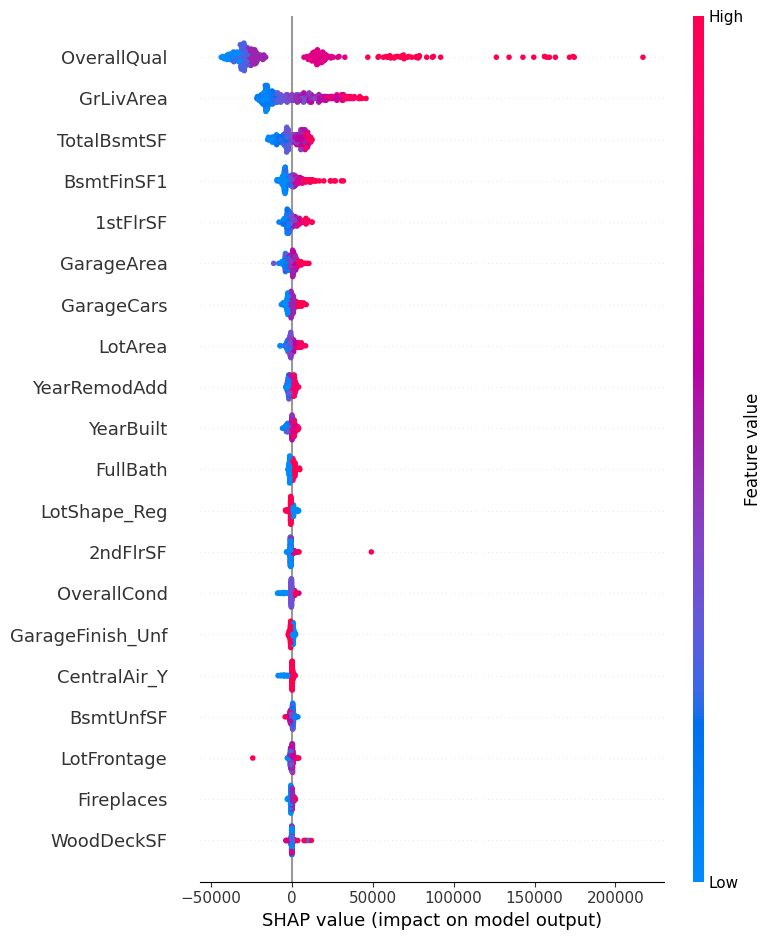

In [42]:
shap.summary_plot(shap_values, X_test)

In [43]:
shap.summary_plot(shap_values[0], X_test)

AssertionError: ignored

In [36]:
shap.plots.bar(shap_values, X_test)

TypeError: ignored

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


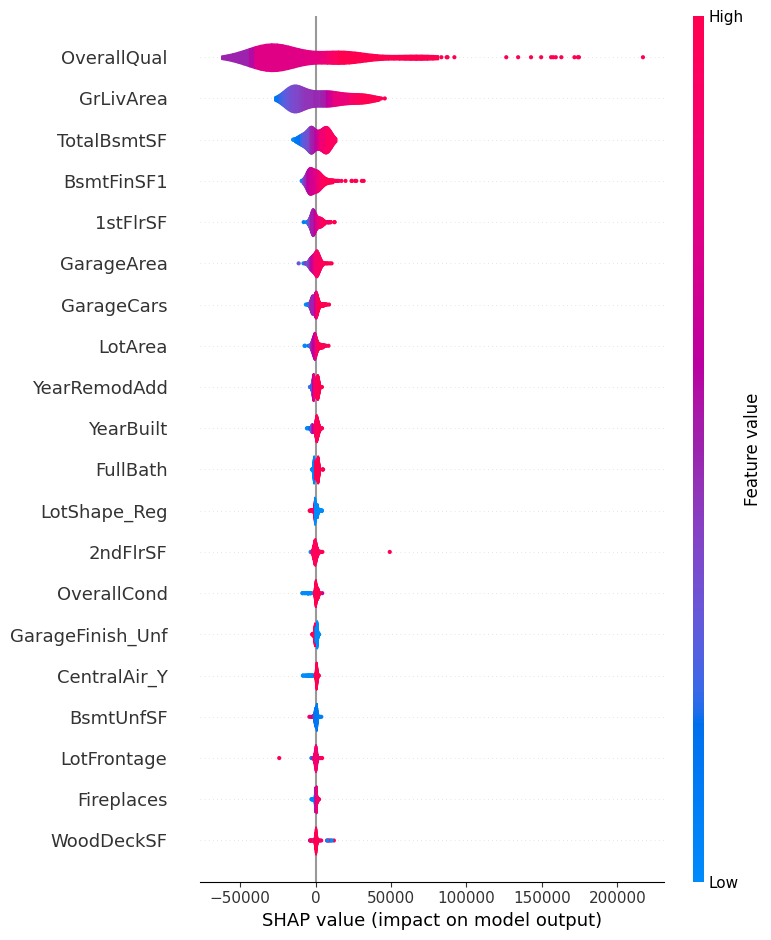

In [44]:
shap.summary_plot(shap_values, X_test, plot_type='violin')

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: ignored

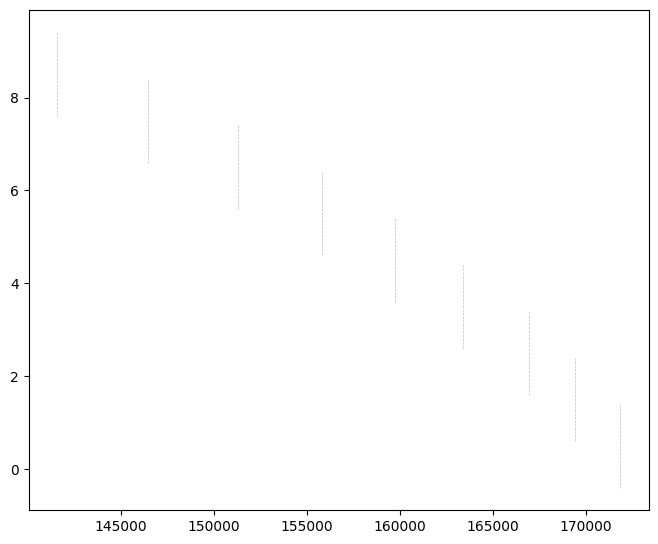

In [61]:
shap.plots.waterfall(shap_values[1])


In [48]:
shap_values

.values =
array([[-1.58611425e+02, -8.01552761e+02, -6.42201028e+02, ...,
         5.86685735e-01, -3.24654234e+02,  2.92556236e+02],
       [ 6.79068707e+00,  5.82320159e+02, -7.73029307e+02, ...,
        -3.89068761e+00,  3.25271702e+01, -4.03020755e+01],
       [-4.90112609e+02, -3.45164132e+02,  2.76429519e+02, ...,
        -6.37012671e+00,  1.59361077e+02, -2.35782199e+01],
       ...,
       [ 9.84682623e+01, -5.84627060e+02, -1.07187315e+03, ...,
         7.61649889e+00,  1.32886292e+02, -2.53003975e+01],
       [ 4.87537435e+01,  2.50239170e+02,  1.27285473e+03, ...,
         3.00983545e+01, -7.97840769e+01,  6.61310742e+02],
       [ 9.74725351e+01, -2.60477316e+02,  2.14439038e+02, ...,
         1.38254220e+00, -7.36465146e+02, -2.15228104e+01]])

.base_values =
array([[179491.3652911],
       [179491.3652911],
       [179491.3652911],
       [179491.3652911],
       [179491.3652911],
       [179491.3652911],
       [179491.3652911],
       [179491.3652911],
       [179491.36

In [49]:
shap_values[0]

.values =
array([-1.58611425e+02, -8.01552761e+02, -6.42201028e+02, -2.52399799e+03,
       -2.23021970e+04, -3.41996316e+02,  4.31521917e+03,  2.37188023e+03,
       -6.53011436e+01,  1.73356160e+03, -1.72717928e+01,  4.96297825e+02,
       -9.62953548e+03, -7.49783381e+02, -7.06979754e+02,  1.71732595e+01,
       -1.68533480e+04,  1.55261411e+02, -1.87722856e+01,  2.03907618e+03,
       -1.29017336e+02, -1.28108651e+02,  8.10044559e+01, -1.97615837e+02,
       -4.87115164e+02,  1.00038236e+03,  8.38825997e+02,  4.33582713e+03,
       -1.08726287e+01,  1.63013788e+02,  3.61141602e+01, -2.59743087e-01,
       -6.89596243e+01, -5.97798896e+00,  1.64646334e+01,  2.58916875e+01,
        4.75478301e+01, -9.56799484e+00,  2.43186287e+00, -3.41834211e+02,
       -1.29566626e+03, -1.79526705e-01, -1.00145063e+01, -6.14938213e-01,
        3.57868647e-01, -5.27043492e+02, -1.90022957e+01, -2.20749124e+00,
       -1.13502639e+01,  1.92053353e-01, -6.57245330e+00,  8.62809148e+00,
       -4.20350

In [50]:
explanation = shap.Explanation(values=shap_values.values, base_values=shap_values.base_values, data=X_test.iloc[0])


IndexError: ignored

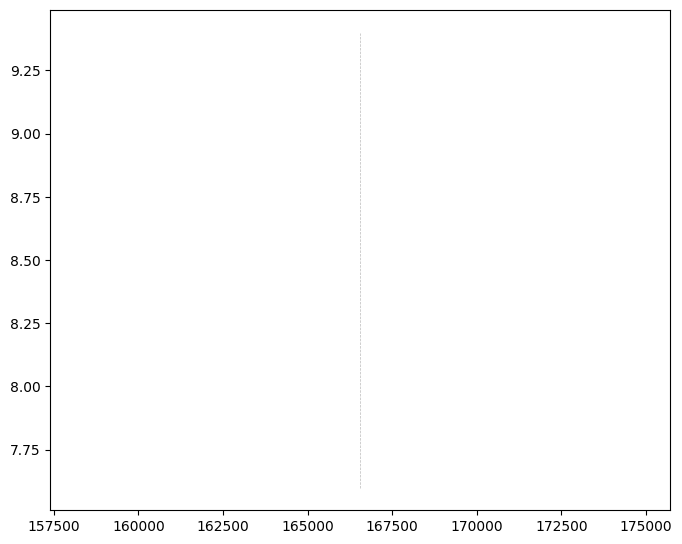

In [54]:
shap.plots.waterfall(explanation[0])

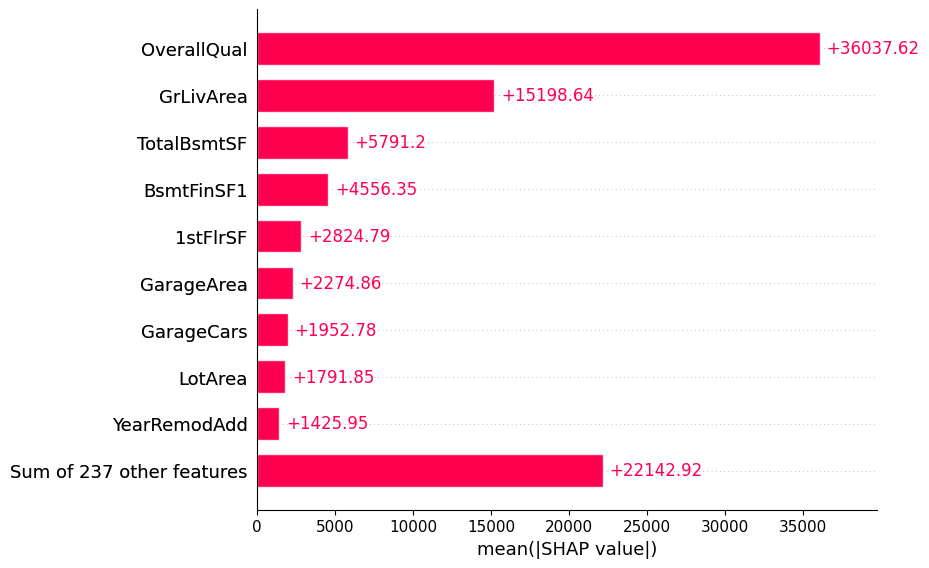

In [57]:
shap.plots.bar(shap_values)

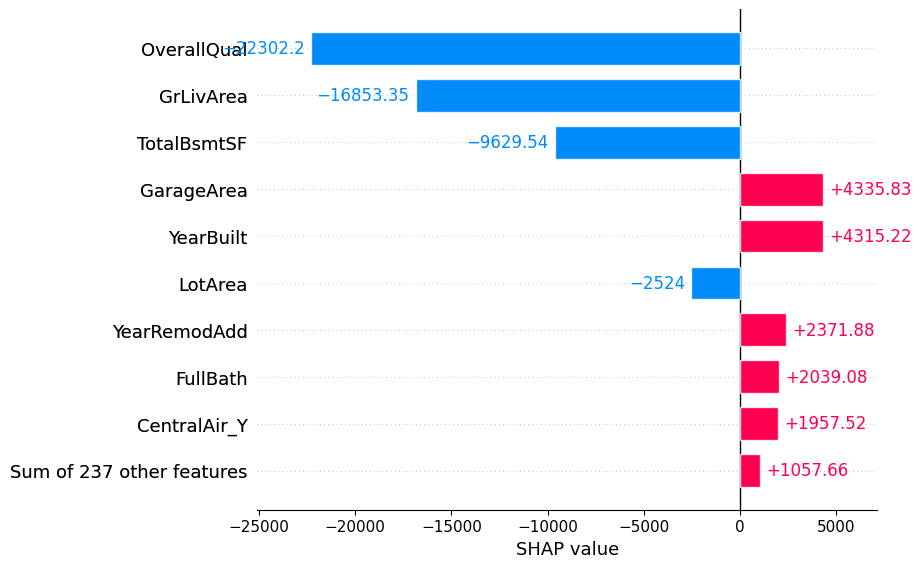

In [62]:
shap.plots.bar(shap_values[0])


In [64]:
shap.plots.force(shap_values[0])


In [74]:
shap.dependence_plot("OverallQual", shap_values[0], X_test,interaction_index="Street")

TypeError: ignored

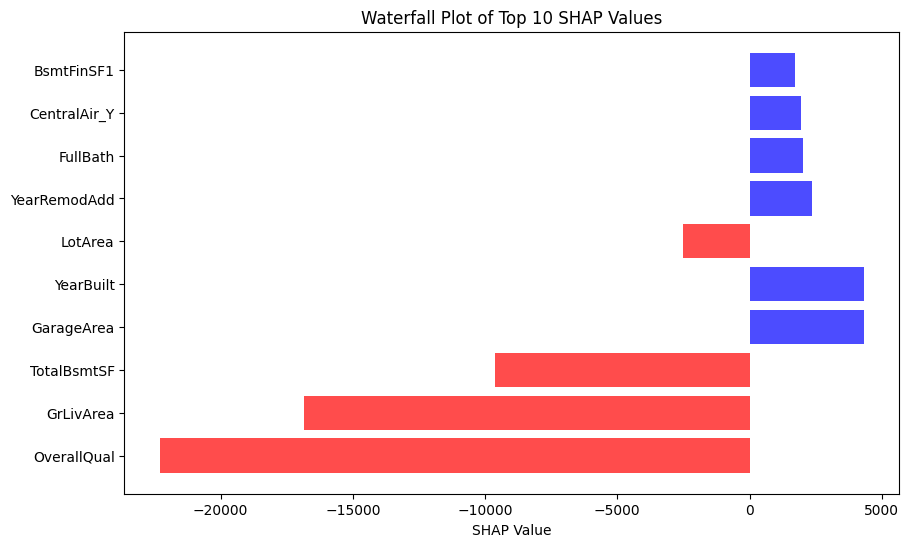

In [72]:
import matplotlib.pyplot as plt
import numpy as np

shap_values_first = explainer(X_test.iloc[0])

# Get the feature names and values for the specific instance
feature_names = X.columns
feature_values = X_test.iloc[0]

# Flatten the SHAP values and sort them by absolute magnitude
shap_values_flat = shap_values.values[0]
sorted_indices = np.argsort(np.abs(shap_values_flat))[::-1]

# Select the top 10 SHAP values
top_indices = sorted_indices[:10]

# Create a waterfall plot for the top 10 SHAP values
plt.figure(figsize=(10, 6))
bar_colors = ['b' if val >= 0 else 'r' for val in shap_values_flat[top_indices]]
plt.barh(np.array(feature_names)[top_indices], shap_values_flat[top_indices], color=bar_colors, alpha=0.7)
plt.xlabel('SHAP Value')
plt.title('Waterfall Plot of Top 10 SHAP Values')
plt.show()